# Seminar 2: Linear Regression, LSE, SVD  


In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
np.random.seed(42)
warnings.filterwarnings("ignore")

## 1D signal reconstriction with Least Squares Estimation and Singular Value Decomposition

#### Here we build a "signal" $f$ represented as a sum of two sinusoidal functions.

In [2]:
a1 = 10.
a2 = 1.
w1 = 1.
w2 = 12.
N = 256

In [3]:
x = np.linspace(-4, 4, N)
f = a1 * np.sin(w1 * x) + a2 * np.sin(w2 * x)

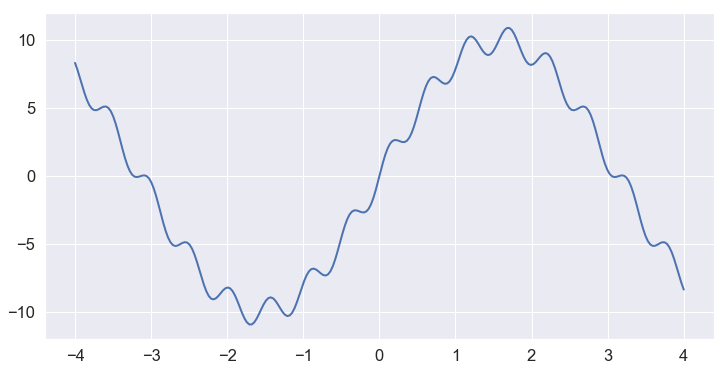

In [4]:
plt.figure(figsize=(12,6))
plt.plot(x, f, linewidth=2)

We generate a "measurement operator" $A$ represented as a K-diagonal matrix (i.e., its K first diagonals are nonzero).

The "measurement" operation performed with this kind of an operator looks like a convolution with a constant kernel.

In [5]:
A = np.eye(N)
for k in range(1, 15):
    A += np.diag(np.ones(N), k=k)[:N, :N]
    A += np.diag(np.ones(N), k=-k)[:N, :N]

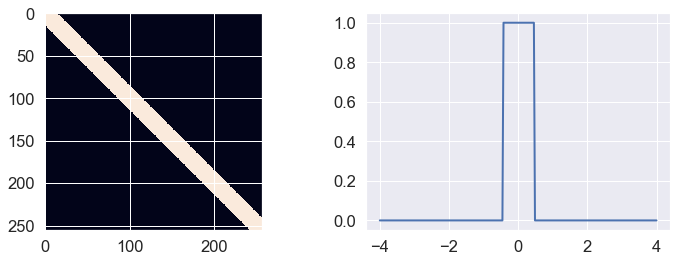

In [6]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].imshow(A)
axs[1].plot(x, A[N // 2,:], linewidth=2)

We "measure" by multiplying our source signal $f$ by our measurement operator $A$: $\xi = A f$.

Effectively we average over consecutive windows.

In [7]:
sigma = 2
noise = sigma * np.random.randn(N)
xi = np.dot(A, f) + noise

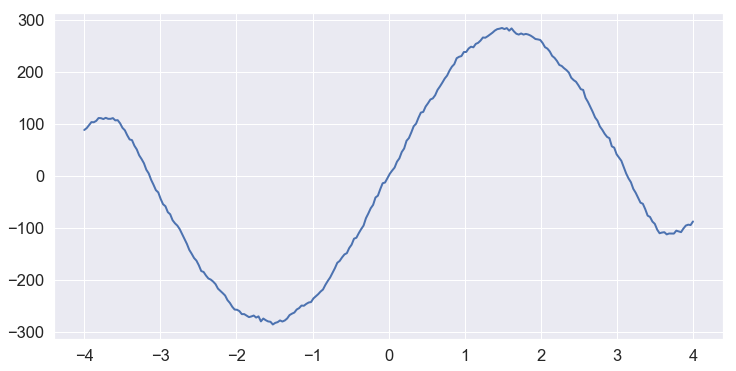

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(x, xi, linewidth=2)

### 1. A LEAST SQUARES ESTIMATE

We try to recover $f$ using a Least Squares Estimate:

$$Af = \xi$$

The pseudo-inverse matrix is:

$$A^+ = (A^T A)^{-1} A^T$$

Then the solution looks like:

$$f = A^+ \xi$$

In [9]:
R = np.dot(
    np.linalg.inv(np.dot(A.T, A)),
    A.T)
#<YOUR_CODE>
Rxi = np.dot(R, xi)

Text(0.5, 1.0, 'Least Squares reconstruction')

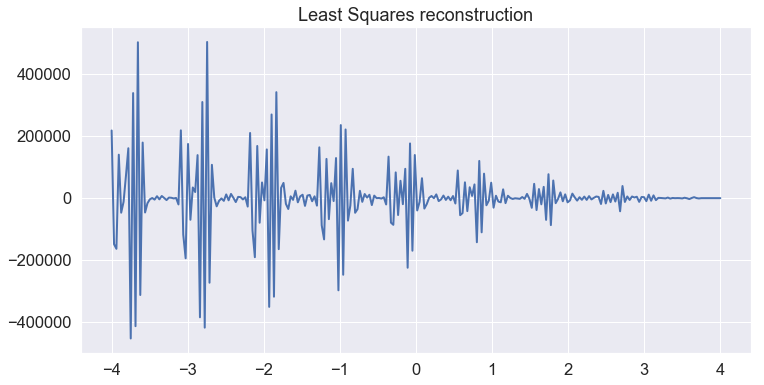

In [10]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi, linewidth=2)
plt.title('Least Squares reconstruction')

## What has happend?

Our implementation of the pseudo-inverse is _poorly conditioned_. See the blackboard for understanding why.

Generally it would be preferable to use specialized implementations of the inverse.
Find more here: https://en.wikipedia.org/wiki/Generalized_inverse

In [11]:
np.linalg.pinv?

In [12]:
R_pinv = np.linalg.pinv(A) #<YOUR_CODE> 
R_pinv_xi = np.dot(R_pinv, xi)

Text(0.5, 1.0, 'Reconstruction with np.linalg.pinv')

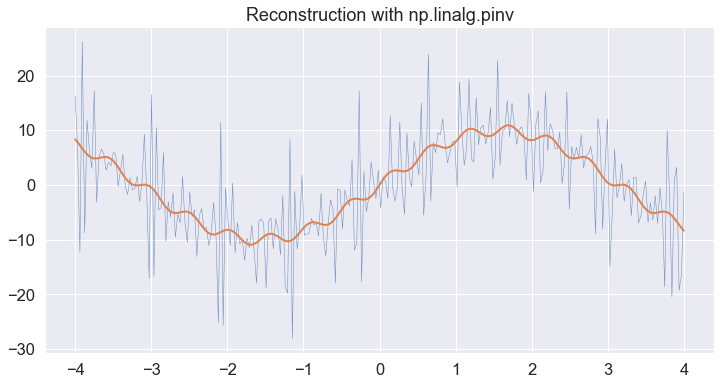

In [13]:
plt.figure(figsize=(12,6))
plt.plot(x, R_pinv_xi, linewidth=0.5, alpha=0.8)
plt.plot(x, f, linewidth=2)
plt.title('Reconstruction with np.linalg.pinv')

### REGULARIZE!

In [14]:
c = 1e4
R_reg = np.dot(
    np.linalg.inv(np.dot(A.T, A) + c * np.eye(N, N)),
    A.T) #<YOUR_CODE>
Rxi_reg = np.dot(R_reg, xi)

Text(0.5, 1.0, 'Regularized reconstruction')

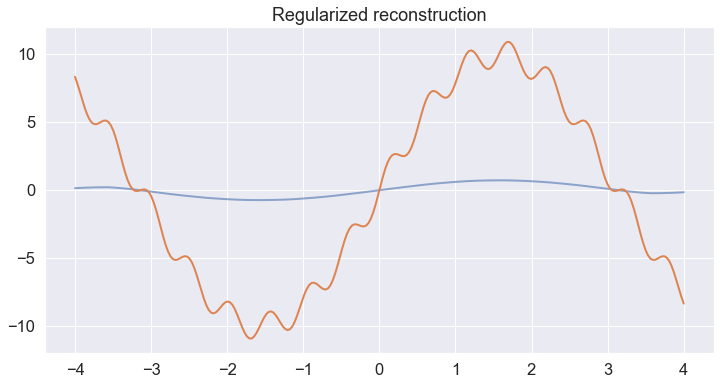

In [15]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Regularized reconstruction')

#### How does one choose the regularization parameter?

In [16]:
reg_coeffs = np.linspace(0.1, 20, 80)
reg_loss = []
for c in reg_coeffs:
    R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N, N)),
        A.T) #<YOUR_CODE> 
    Rxi_reg = np.dot(R_reg, xi)
    loss = np.sum((f - Rxi_reg)**2)
    reg_loss.append(loss)

Text(0.5, 1.0, 'MSE depending on the regularization parameter')

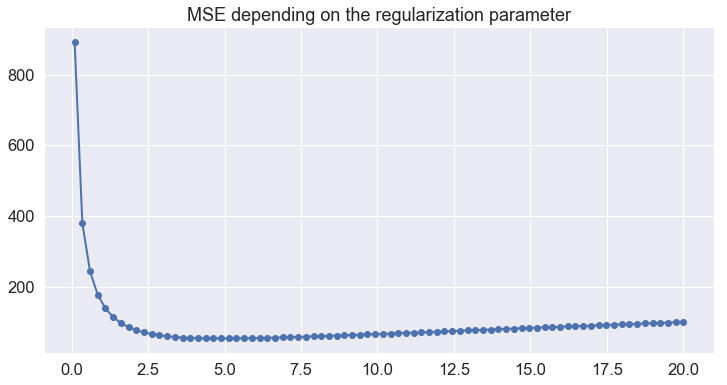

In [17]:
plt.figure(figsize=(12,6))
plt.plot(reg_coeffs, reg_loss, 'o-', linewidth=2)
plt.title('MSE depending on the regularization parameter')

In [18]:
reg_coeffs[np.argmin(reg_loss)]

4.886075949367087

In [19]:
c = reg_coeffs[np.argmin(reg_loss)]
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N, N)),
        A.T) #<YOUR_CODE>
Rxi_reg = np.dot(R_reg, xi)

Text(0.5, 1.0, 'Regularized reconstruction (optimal regularization)')

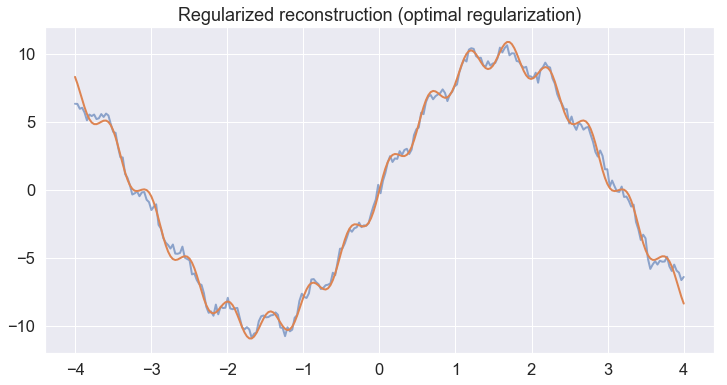

In [20]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Regularized reconstruction (optimal regularization)')

# 2. Singular Value Decomposition

### A bit of theory on how this all works: 

$$A_{n \times m } = U_{m \times m } \Sigma_{m \times n } V_{n \times n }$$

In [21]:
np.linalg.svd?

In [22]:
U, S, V = np.linalg.svd(A)

Text(0.5, 1.0, 'Eigenvalues of $A$')

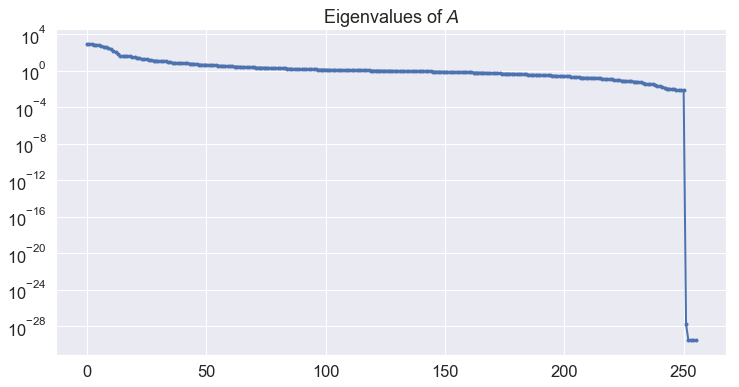

In [23]:
plt.figure(figsize=(12,6))
plt.semilogy(S**2, '.-', linewidth=2)
plt.title('Eigenvalues of $A$')

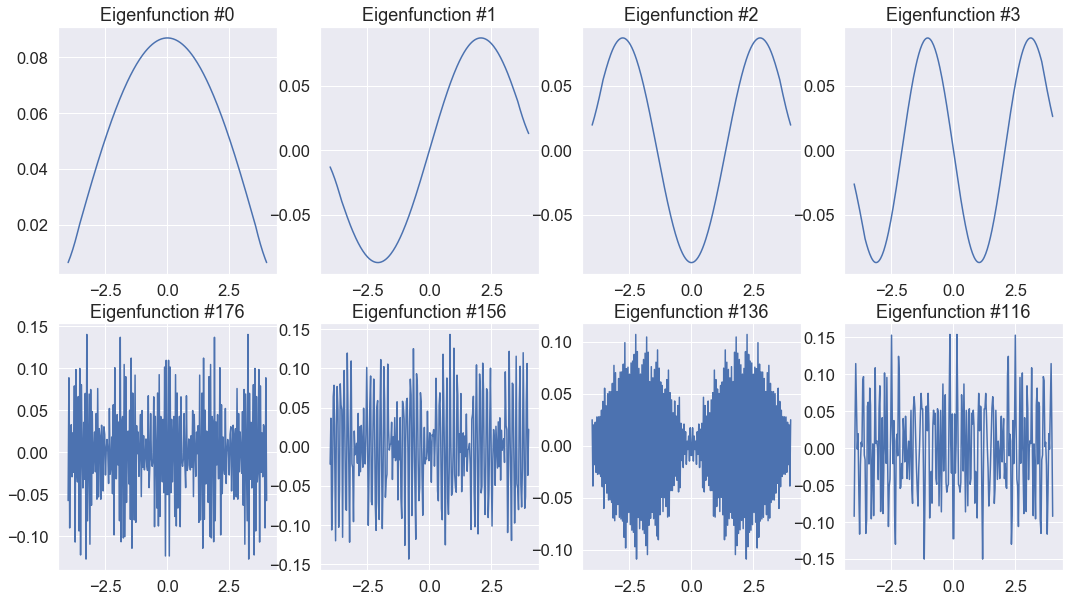

In [24]:
fig, axs = plt.subplots(figsize=(18, 10), ncols=4, nrows=2)
for i in range(4):
    axs[0, i].plot(x, V[i])
    axs[0, i].set_title('Eigenfunction #{}'.format(i))
for i in range(4):
    axs[1, i].plot(x, V[N-(4 + i) * 20])
    axs[1, i].set_title('Eigenfunction #{}'.format(N-(4 + i) * 20))

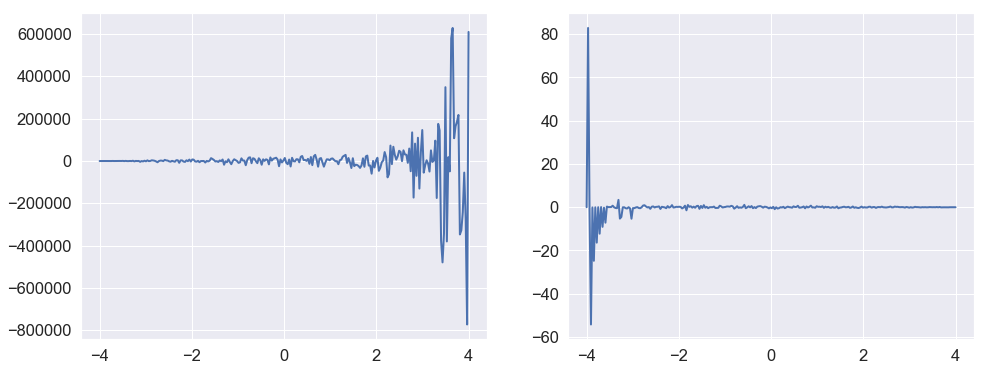

In [25]:
# Filtered signal 
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(x, np.dot(V, Rxi), linewidth=2)
axs[1].plot(x, np.dot(V, Rxi_reg), linewidth=2)

### We _change the basis_ to be the _eigenbasis_ of $A$ and do the very same actions as before

How does one change the basis to $A$'s basis, knowing $U$, $V$, and $S$ matrixes?

In [26]:
f_wave = np.dot(V, f) 
noise_wave = np.dot(V, noise) 

In [27]:
A_wave = np.diag(S)

In [28]:
xi_wave = np.dot(A_wave, f_wave) + noise_wave

Text(0.5, 1.0, 'Filtered signal after measurement')

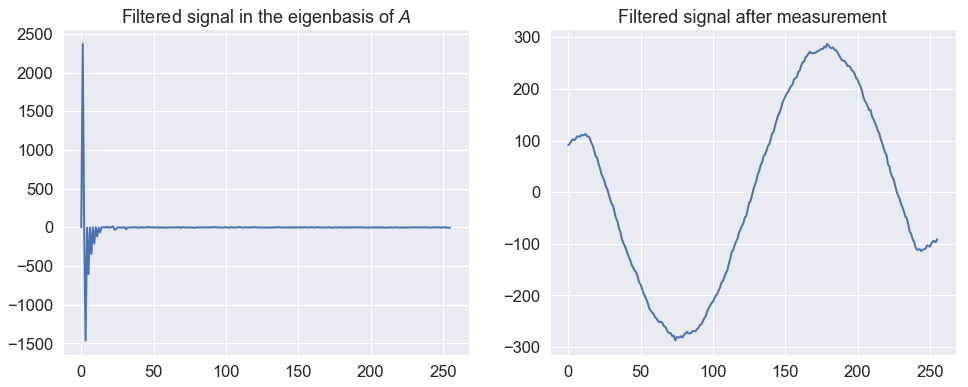

In [29]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)

axs[0].plot(xi_wave, linewidth=2)
axs[0].set_title('Filtered signal in the eigenbasis of $A$')

# Our xi_wave - signal in basis of A operator
# let's return to the prevous basis to show that the signals are the same
axs[1].plot(np.dot(V.T, xi_wave), linewidth=2) 
axs[1].set_title('Filtered signal after measurement')

Let's now perform inversion in the very same basis.

In [ ]:
R_wave =  #<YOUR_CODE>
R_wave_xi = np.dot(R_wave, xi_wave)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_wave), '.-', linewidth=2)
plt.title('Smoker\'s inverse')
plt.yscale('log')

In [ ]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi, linewidth=2)
axs[0].set_title('Reconstructed signal in the operators\' basis')

axs[1].plot(np.dot(V.T, R_wave_xi), linewidth=2)
axs[1].set_title('Reconstructed signal')

More precision-related issues :(

In [33]:
R_pinv_wave = np.linalg.pinv(A_wave)
R_pinv_wave_xi = np.dot(R_pinv_wave, xi_wave)

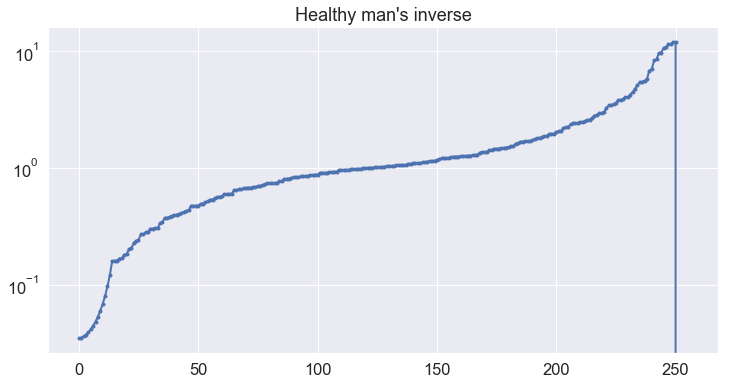

In [34]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_pinv_wave), '.-', linewidth=2)
plt.title('Healthy man\'s inverse')
plt.yscale('log')

Text(0.5, 1.0, 'Reconstructed signal')

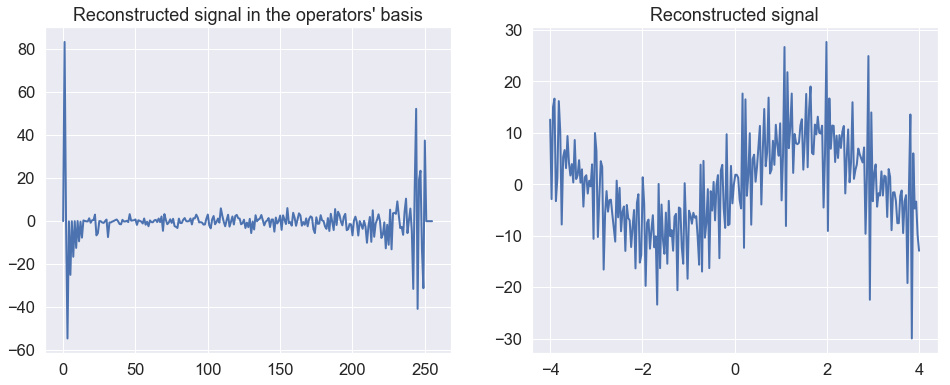

In [35]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_pinv_wave_xi, linewidth=2)
axs[0].set_title('Reconstructed signal in the operators\' basis')

axs[1].plot(x, np.dot(V.T, R_pinv_wave_xi), linewidth=2)
axs[1].set_title('Reconstructed signal')

In [ ]:
c = reg_coeffs[np.argmin(reg_loss)]
R_wave_reg = #<YOUR_CODE>
R_wave_xi_reg = np.dot(R_wave_reg, xi_wave)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.diag(R_wave_reg), '.-', linewidth=2)

In [ ]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi_reg, linewidth=2)
axs[0].plot(f_wave, linewidth=2)
axs[0].set_title('Reconstructed signal in the operators\' basis')


axs[1].plot(x, np.dot(V.T, R_wave_xi_reg), linewidth=2)
axs[1].set_title('Reconstructed signal')